<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cosmos-HST" data-toc-modified-id="Cosmos-HST-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cosmos HST</a></span><ul class="toc-item"><li><span><a href="#Exposure-files" data-toc-modified-id="Exposure-files-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exposure files</a></span></li><li><span><a href="#Make-cutouts" data-toc-modified-id="Make-cutouts-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Make cutouts</a></span></li></ul></li></ul></div>

# Cosmos HST

Check coverage of grizli-processed HST imaging in COSMOS

In [1]:
import os
import numpy as np
from grizli import utils

In [2]:
tab = utils.read_catalog('cosmos_HST_exposure_catalog_2020.03.09.fits')
xfootprints = np.load('cosmos_HST_exposure_catalog_2020.03.09_footprints.npy', 
                     allow_pickle=True)

# Data format issue
footprints = [[fp[0], fp[1]] for fp in xfootprints]

In [3]:
import astropy.units as u

def check_hst_overlaps(ra, dec, tab, footprints, label=None, sep=3*u.arcmin):
    """
    Check overlapping HST exposures at a given position
    """
    #sep = 10*u.arcmin
    from grizli import utils
    
    from matplotlib.patches import PathPatch
    from matplotlib.path import Path
    import matplotlib.pyplot as plt
    
    this = utils.GTable()
    this['ra'] = [ra]
    this['dec'] = [dec]

    idx, dr = this.match_to_catalog_sky(tab)
    near = dr < sep

    fig, ax = plt.subplots(1,1,figsize=(5,5))
    if label is None:
        label = f'{ra:.6f} {dec:.6f}'
        
    ax.scatter([ra], [dec],  color='r', marker='*', zorder=100, label=label)
    ax.scatter(tab['ra'][near], tab['dec'][near], marker='+', color='0.8')

    in_patch = near & True

    for i in np.where(near)[0]:
        path = Path(np.array(footprints[i]).T)
        in_path = path.contains_point((ra, dec))
        if in_path:
            patch = PathPatch(path, color='orange', alpha=0.2)
        else:
            patch = PathPatch(path, color='k', alpha=0.1)
            in_patch[i] = False

        ax.add_patch(patch)
    
    cosd = np.cos(dec/180*np.pi)
    ax.set_aspect(1/cosd)
    ax.grid()
    ax.legend(loc='upper center')
    ax.set_xlim(*ax.get_xlim()[::-1])
    
    fig.tight_layout(pad=0.5)
    
    return fig, in_patch

In [4]:
# Kriek et al. monster massive galaxy
ra, dec, label = 150.07393, 2.2980, 'monster'

# No filter preselection
sel_filts = None 

# Limit filters
sel_filts = ['f160w','f125w']

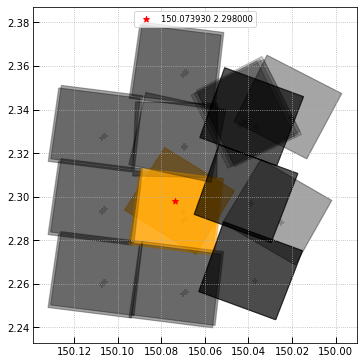

In [5]:
if sel_filts is not None:
    sel = np.zeros(len(tab), dtype=bool)
    for f in sel_filts:
        sel |= tab['filter'] == f
    
    sel = np.where(sel)[0]
    tab_sel = tab[sel]
    fp_sel = [footprints[i] for i in sel]
    
else:
    tab_sel = tab
    fp_sel = footprints
    
_fig, _sel = check_hst_overlaps(ra, dec, tab_sel, fp_sel, sep=4*u.arcmin)

In [6]:
tab_sel[_sel]

ra,dec,file,filter,root
deg,deg,,,
float64,float64,bytes18,bytes6,bytes57
150.07008553622828,2.293237871189638,ibhg01k2q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.0699313110156,2.2931998906533417,ibhg01k3q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.06993266857899,2.2932987335726005,ibhg01k4q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.07008685502765,2.2933366721988113,ibhg01k5q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.0699905066064,2.288647196559313,iboa22eiq_flt.fits,f160w,j100028p0214_0022_boa_cosmos-v22_wfc3ir_f160w
150.07023401856912,2.2886595205890883,iboa22emq_flt.fits,f160w,j100028p0214_0022_boa_cosmos-v22_wfc3ir_f160w
150.07004318945505,2.288801531977349,iboa22egq_flt.fits,f125w,j100028p0214_0047_boa_cosmos-v22_wfc3ir_f125w
150.07028510835207,2.288813619149606,iboa22epq_flt.fits,f125w,j100028p0214_0047_boa_cosmos-v22_wfc3ir_f125w


## Exposure files

In [7]:
# Exposures
url = 'https://s3.amazonaws.com/cosmos-dash/Pipeline/{root}/Prep/{file}'

i = 0
url_i = url.format(root=tab_sel[_sel]['root'][i], file=tab_sel[_sel]['file'][i])
#os.system('wget ')
print(url_i)

https://s3.amazonaws.com/cosmos-dash/Pipeline/j100028p0214_0000_bhg_cos7712_wfc3ir_f160w/Prep/ibhg01k2q_flt.fits


In [8]:
# Fetch exposure data
if False:
    os.system(f'wget {url_i}')

## Make cutouts

These aren't cutouts directly from full mosaics but are rather redrizzled from the individual FLT files with the specified drizzle parameters (pixel scale, pixfrac) and desired cutout dimentions.

In [9]:
import os
HOME = os.getenv('HOME')
if not os.path.exists(f'{HOME}/.aws'):
    os.mkdir(f'{HOME}/.aws')

# Put your AWS credentials here. 
# Files are public but still need account to fetch them.
if not os.path.exists(f'{HOME}/.aws/credentials'):
    print(f'Initialize {HOME}/.aws/credentials')
    with open(f'{HOME}/.aws/credentials','w') as fp:
        fp.write("""
[default]
aws_access_key_id=
aws_secret_access_key=
""")

In [10]:
from IPython.display import Image, display, HTML
from grizli.aws import aws_drizzler
import os

master = 'cosmos-dash-mar06'

filters = ['f160w','f125w']

kwargs = dict(pixscale=0.1,                  # pixel size
              size=10,                       # cutout size in arcsec
              pixfrac=0.25, kernel='square', # Drizzle params
              remove=True,                   # Remove intermediate files
              aws_bucket=None, master=master, get_dict=False, 
              filters=filters,               # Filters to use
              include_ir_psf=False           # Include extensions for IR ePSF
              )

In [11]:
if not os.path.exists(f'{label}.rgb.png'):
    _ = aws_drizzler.drizzle_images(label=label, ra=ra, dec=dec, 
                **kwargs)

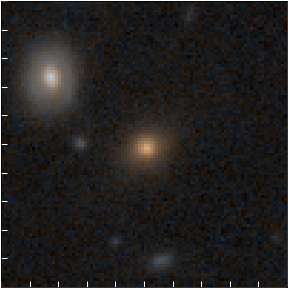

In [12]:
display(Image('monster.rgb.png'))

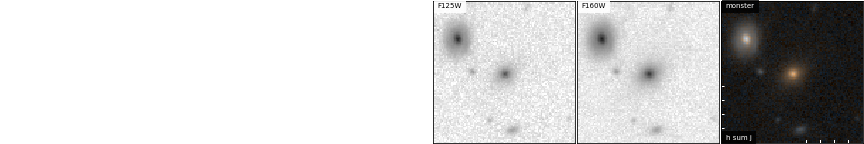

In [13]:
# Paneels filled in on the left when bluer filters available
display(Image('monster.thumb.png'))

In [14]:
!ls 

Dockerfile
LICENSE
README.md
cosmos-dash-mar06_filter_groups.npy
cosmos_HST_exposure_catalog_2020.03.09.fits
cosmos_HST_exposure_catalog_2020.03.09_footprints.npy
coverage.ipynb
